In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0664.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1269.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0733.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0106.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0375.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1075.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0285.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0591.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0799.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1411.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0074.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/1031.jpg
/kaggle/input/autism-image-data/AutismDataset/consolidated/Autistic/0077.jpg

In [2]:
import os
!pip install split_folders
import random
import splitfolders
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG16,VGG19, Xception, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
import tensorflow_hub as hub
import tensorflow as tf


# Download and save detection model
def download_and_save_detection_model(model_url, save_path):
    model = hub.load(model_url)
    tf.saved_model.save(model, save_path)

# Load detection model from file
def load_detection_model(model_path):
    model = tf.saved_model.load(model_path)
    return model

# Define model names
model_names = ['VGG19', 'VGG16', 'Xception', 'MobileNetV2', 'InceptionV3', 'ResNet50']
detection_model_path = "detection_model.keras"

In [4]:
detection_model = load_detection_model(detection_model_path)

In [5]:
# Set the dataset location
loc = "/kaggle/input/autism-image-data/AutismDataset/consolidated"  # Update this path accordingly

# Create output directories
os.makedirs('output', exist_ok=True)
os.makedirs('output/train', exist_ok=True)
os.makedirs('output/val', exist_ok=True)
os.makedirs('output/test', exist_ok=True)

# Split data into training, validation, and test sets
splitfolders.ratio(loc, output="output", seed=0, ratio=(0.80, 0.1, 0.1))
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

Copying files: 2940 files [00:03, 750.24 files/s] 


In [6]:
# Load data
batch_size = 32
image_size = (224, 224)
train_data = image_dataset_from_directory(train_dir, batch_size=batch_size, image_size=image_size, label_mode='categorical', shuffle=True, seed=0)
test_data = image_dataset_from_directory(test_dir, batch_size=batch_size, image_size=image_size, label_mode='categorical', shuffle=False, seed=0)
val_data = image_dataset_from_directory(val_dir, batch_size=batch_size, image_size=image_size, label_mode='categorical', shuffle=False, seed=0)

class_names = train_data.class_names
class_count = len(class_names)

Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [7]:
def create_model(model_name):
    input_shape = (224, 224, 3)
    base_model = None
    
    print(f"Creating model: {model_name}")  # Debugging statement

    if model_name == 'VGG19':
        base_model = VGG19(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'VGG16':
        base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'Xception':
        base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    else:
        raise ValueError(f"Unknown model name: {model_name}")  # Raise an error for unknown model names

    if base_model is None:
        raise RuntimeError(f"Failed to create base model for: {model_name}")  # Ensure base_model is created

    # Add custom layers
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.002)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.45, seed=0)(x)
    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def plot_graphs(epochs, train_accuracies, val_accuracies, train_losses, val_losses, y_test, y_pred, class_names, model_name):
    # Combined Accuracy and Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracies, label='Val Accuracy', color='orange')
    plt.plot(range(epochs), train_losses, label='Train Loss', linestyle='--', color='green')
    plt.plot(range(epochs), val_losses, label='Val Loss', linestyle='--', color='red')
    plt.title(f'Accuracy and Loss vs Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convert y_test and y_pred to binary format for each class (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))
    y_pred_bin = label_binarize(y_pred, classes=list(range(len(class_names))))

    # Combined plot of Precision-Recall, F1-Score vs Recall, and ROC Curves in one graph
    plt.figure(figsize=(12, 8))
    
    # Ensure the number of classes in y_test_bin and y_pred_bin match class_names length
    num_classes = len(class_names)
    for i in range(num_classes):
        # Precision-Recall
        if y_test_bin.shape[1] > i and y_pred_bin.shape[1] > i:
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
            plt.plot(recall, precision, label=f'Precision-Recall ', linestyle='-')
            
            # F1-Score vs Recall
            f1_scores = 2 * (precision * recall) / (precision + recall)
            plt.plot(recall, f1_scores, label=f'F1-Score vs Recall ', linestyle='--')
    
    # ROC Curve
    for i in range(num_classes):
        if y_test_bin.shape[1] > i and y_pred_bin.shape[1] > i:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'(ROC , AUC = {roc_auc:.2f})', linestyle='-.')
    
    # Adding labels, title, and legend
    plt.title(f'Combined Precision-Recall, F1-Score vs Recall, and ROC Curve for {model_name}')
    plt.xlabel('Recall / FPR (for ROC)')
    plt.ylabel('Precision / TPR / F1-Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
def train_and_evaluate_model(model, train_data, val_data, test_data, model_name, class_names):
    epochs = 50
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Define the callback for saving the best model
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{model_name}_best_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )

    # Loop over epochs manually
    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}/{epochs}")  # Debugging line
        history = model.fit(
            train_data,
            epochs=1,  # Train for 1 epoch at a time
            validation_data=val_data,
            verbose=1,
            callbacks=[checkpoint_cb]
        )
        print(f"Finished epoch {epoch + 1}")  # Debugging line
        train_accuracies.append(history.history['accuracy'][0])
        val_accuracies.append(history.history['val_accuracy'][0])
        train_losses.append(history.history['loss'][0])
        val_losses.append(history.history['val_loss'][0])

    # Load the best model
    best_model = tf.keras.models.load_model(f"{model_name}_best_model.keras")

    # Evaluate on the test dataset
    test_loss, test_accuracy = best_model.evaluate(test_data)
    print(f"Test Accuracy for {model_name}: {test_accuracy}")

    # Collect test data and labels
    test_data_array = []
    labels_array = []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    # Make predictions on the test dataset
    y_pred_probs = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Print classification report
    print(classification_report(y_test_labels, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Plot accuracy and loss graphs
    plot_graphs(epochs, train_accuracies, val_accuracies, train_losses, val_losses, y_test_labels, y_pred, class_names, model_name)



In [10]:
def predict_spectrum(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)

    # Make prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds)
    confidence = preds[0][predicted_class]

    prediction_result = {
        'class': class_names[predicted_class],
        'confidence': confidence
    }

    if class_names[predicted_class] == "Non_Autistic":
        prediction_result['spectrum_severity'] = None
    else:
        if confidence >= 0.9:
            prediction_result['spectrum_severity'] = "Severe"
        elif confidence >= 0.7:
            prediction_result['spectrum_severity'] = "Moderate"
        else:
            prediction_result['spectrum_severity'] = "Mild"
    
    return prediction_result

In [11]:
def detect_and_visualize(detection_model, image_path, model,img_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image {image_path}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization
    img_resized = cv2.resize(img_rgb, (512, 512))  # Resize for detection model input
    
    # Run object detection
    boxes, classes, scores = detect_objects(detection_model, img_resized)
    
    # Draw bounding boxes
    img_with_boxes = draw_boxes(img_resized, boxes, classes, scores)
    
    # Predict spectrum for each image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)
    prediction_result = predict_spectrum(model, image_path, class_names)
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds)
    # Visualize the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_boxes)
    if class_names[predicted_class] == "Autistic":
        plt.title(f"Prediction: {prediction_result['class']} at a spectrum level of: {prediction_result['confidence']*100:.2f}%\n" +
                  f"Spectrum Severity: {prediction_result['spectrum_severity']}")
    else:
         plt.title(f"Prediction: {prediction_result['class']}")
            
    plt.axis('off')
    plt.show()


In [12]:
import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def detect_objects(detection_model, image_np):
    # Convert image to uint8
    image_np = (image_np * 255).astype(np.uint8)
    
    # Create a TensorFlow tensor with the correct shape and dtype
    image_np = tf.convert_to_tensor(image_np[tf.newaxis, ...], dtype=tf.uint8)  # Add batch dimension

    # Perform detection
    results = detection_model(image_np)
    
    # Extract results
    boxes = results['detection_boxes'][0].numpy()
    classes = results['detection_classes'][0].numpy()
    scores = results['detection_scores'][0].numpy()

    return boxes, classes, scores


def draw_boxes(img, boxes, classes, scores, threshold=0.5):
    h, w, _ = img.shape
    for i in range(len(boxes)):
        if scores[i] >= threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            xmin, xmax, ymin, ymax = int(xmin * w), int(xmax * w), int(ymin * h), int(ymax * h)
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            label = f"Class {int(classes[i])}: {scores[i]:.2f}"
            cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return img

def predict_spectrum(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Use the appropriate preprocessing function
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    class_label = class_names[predicted_class]
    
    severity = "Mild" if class_label == "Autistic" else None
    
    return {'class': class_label, 'confidence': confidence, 'spectrum_severity': severity}


def test_random_images_with_detection(detection_model, test_dir, model, class_names, num_images=12, images_per_row=4):
    # List all image files in the directory
    images = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            images.append(os.path.join(root, file))

    # Randomly choose 'num_images' images
    random_images = random.sample(images, num_images)

    # Calculate the number of rows needed
    num_rows = (num_images + images_per_row - 1) // images_per_row

    # Create a matplotlib figure with smaller images
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(12, 3 * num_rows))
    axes = axes.flatten()

    # Run detection and visualization for each random image
    for i, img_path in enumerate(random_images):
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image {img_path}")
            continue
        
        # Convert color from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Run object detection (optional, if object detection is relevant)
        boxes, classes, scores = detect_objects(detection_model, img_rgb)
        
        # Draw bounding boxes (optional)
        img_with_boxes = draw_boxes(img_rgb, boxes, classes, scores)
        
        # Prediction for spectrum classification
        prediction_result = predict_spectrum(model, img_path, class_names)
        class_label = prediction_result['class']
        severity = prediction_result.get('spectrum_severity', None)
        confidence = prediction_result['confidence']

        # Set title based on classification result
        if class_label == "Non_Autistic":
            title = f"{class_label}"  # No confidence shown for Non_Autistic
        else:
            title = f"{class_label} ({confidence:.2f})"  # Confidence and severity for Autistic images
            if severity:
                title += f"\nSeverity: {severity}"

        # Plot the image
        axes[i].imshow(img_with_boxes)
        axes[i].set_title(title)
        axes[i].axis('off')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



Creating model: VGG19
Training and evaluating model: VGG19
Starting epoch 1/50


I0000 00:00:1725901383.319182    2077 service.cc:145] XLA service 0x7ef4d0003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725901383.319240    2077 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725901383.319244    2077 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725901423.179280    2077 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5489 - loss: 1.1026
Epoch 1: val_accuracy improved from -inf to 0.62245, saving model to VGG19_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 114s 945ms/step - accuracy: 0.5495 - loss: 1.1011 - val_accuracy: 0.6224 - val_loss: 1.2689
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7083 - loss: 0.6815
Epoch 1: val_accuracy improved from 0.62245 to 0.70068, saving model to VGG19_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 520ms/step - accuracy: 0.7086 - loss: 0.6808 - val_accuracy: 0.7007 - val_loss: 0.6471
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7964 - loss: 0.4631
Epoch 1: val_accuracy improved from 0.70068 to 0.78231, saving model to VGG19_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 525ms/step - accuracy: 0.7963 - loss: 0.4631 - val_accuracy: 0.7823 - val_loss: 0.5594
Finished epoch 3
Starting epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 

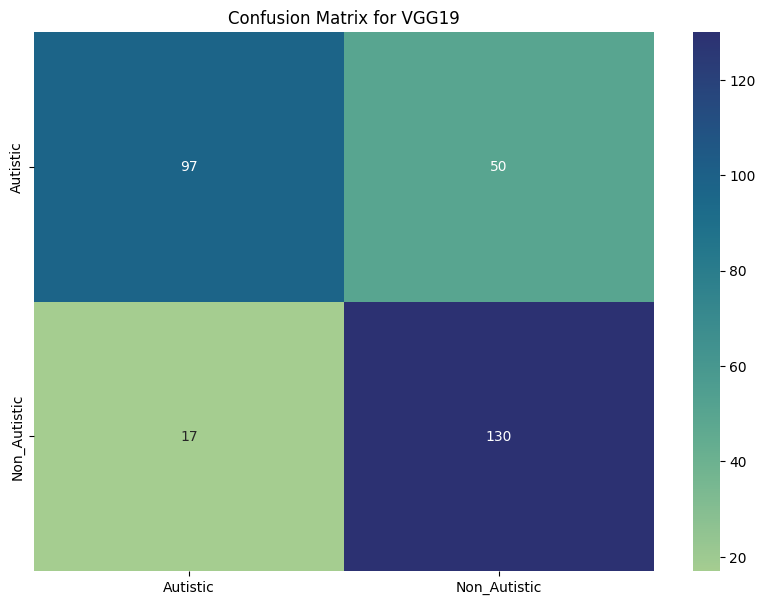

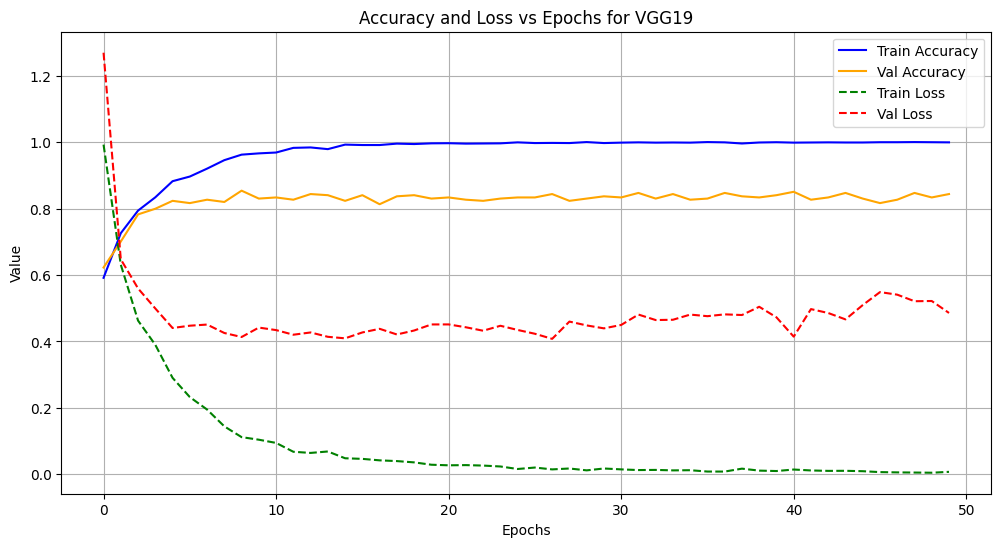

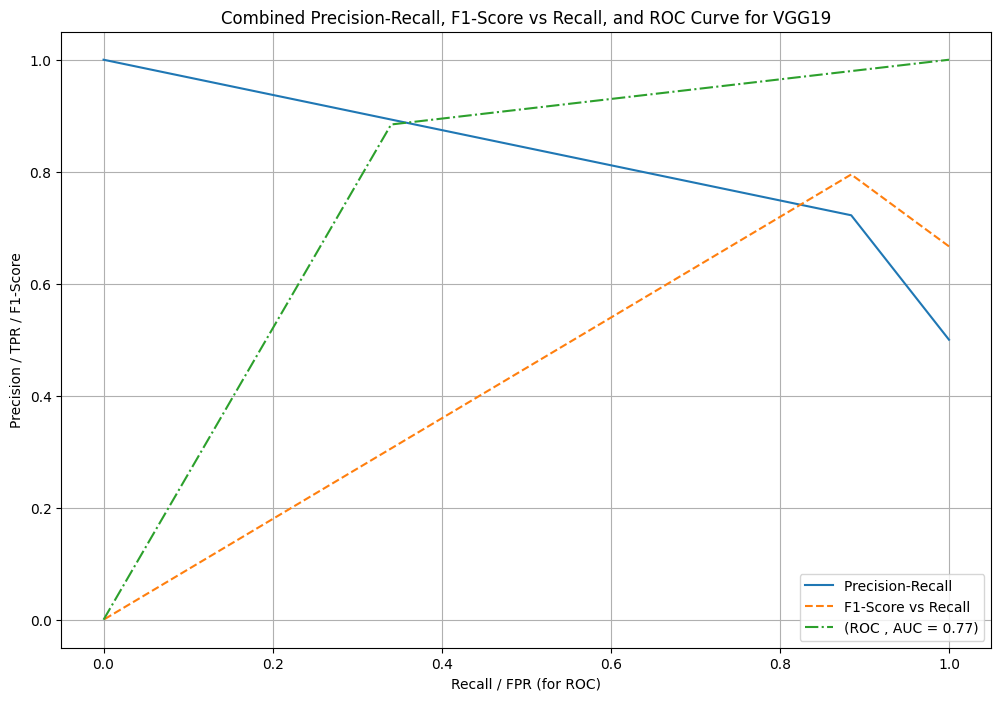

Testing random images with detection model: VGG19
Creating model: VGG16
Training and evaluating model: VGG16
Starting epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.5407 - loss: 1.0898
Epoch 1: val_accuracy improved from -inf to 0.57483, saving model to VGG16_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 122s 884ms/step - accuracy: 0.5410 - loss: 1.0887 - val_accuracy: 0.5748 - val_loss: 0.8312
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7128 - loss: 0.6729
Epoch 1: val_accuracy improved from 0.57483 to 0.65646, saving model to VGG16_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 463ms/step - accuracy: 0.7125 - loss: 0.6731 - val_accuracy: 0.6565 - val_loss: 0.6689
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7350 - loss: 0.5643
Epoch 1: val_accuracy improved from 0.65646 to 0.74150, saving model to VGG16_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - accuracy:

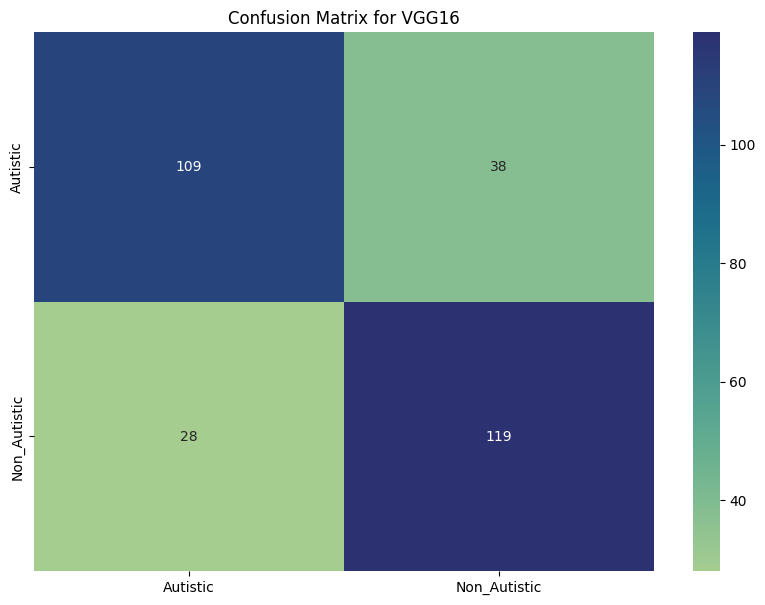

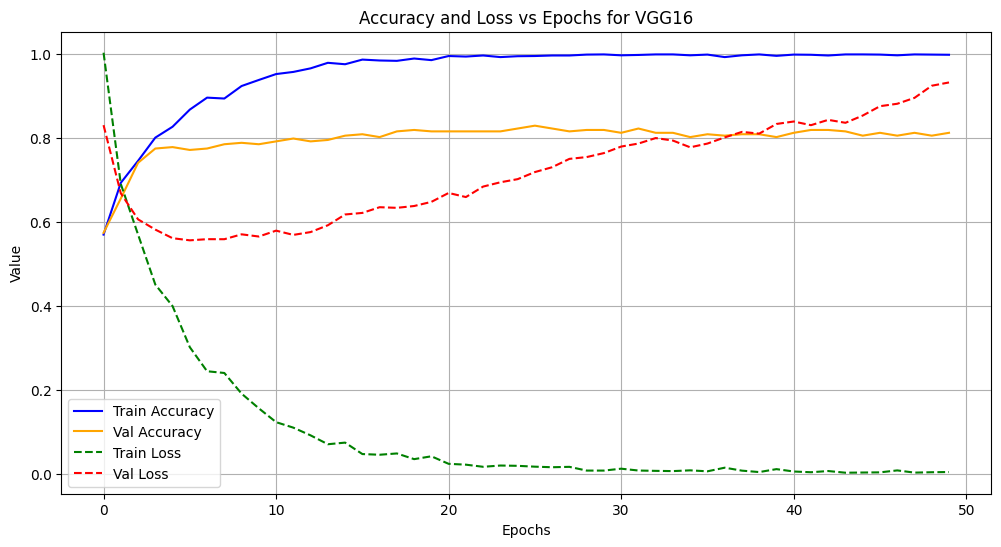

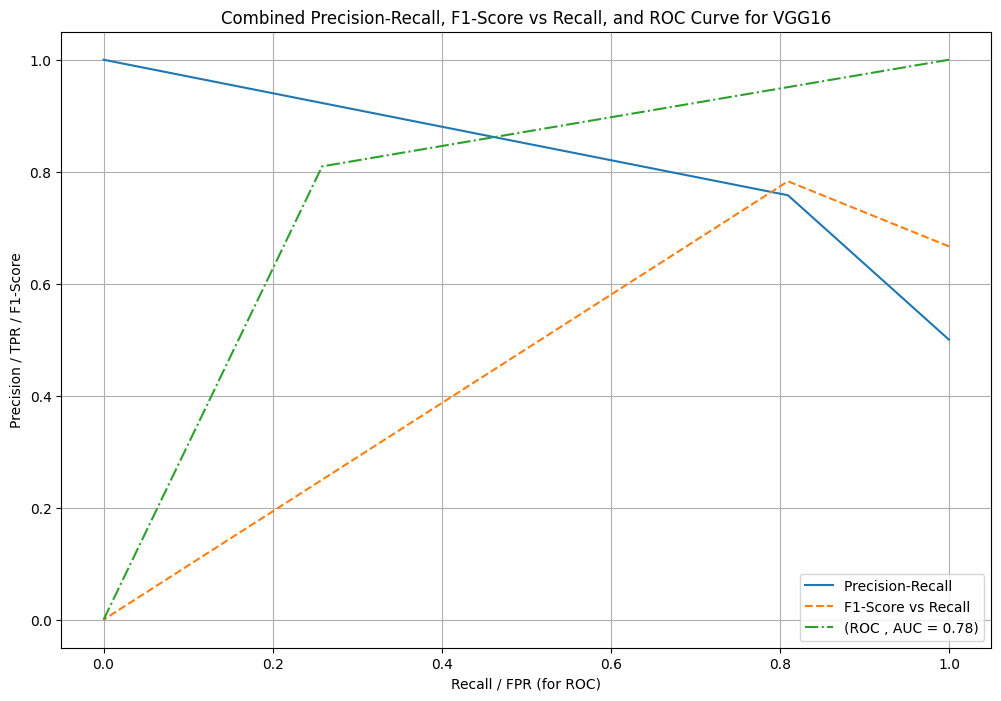

Testing random images with detection model: VGG16
Creating model: Xception
Training and evaluating model: Xception
Starting epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5227 - loss: 1.1583
Epoch 1: val_accuracy improved from -inf to 0.58844, saving model to Xception_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 85s 698ms/step - accuracy: 0.5231 - loss: 1.1572 - val_accuracy: 0.5884 - val_loss: 0.7305
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6798 - loss: 0.7322
Epoch 1: val_accuracy improved from 0.58844 to 0.67007, saving model to Xception_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 487ms/step - accuracy: 0.6798 - loss: 0.7327 - val_accuracy: 0.6701 - val_loss: 0.6121
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7285 - loss: 0.6151
Epoch 1: val_accuracy improved from 0.67007 to 0.71769, saving model to Xception_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 484ms/st

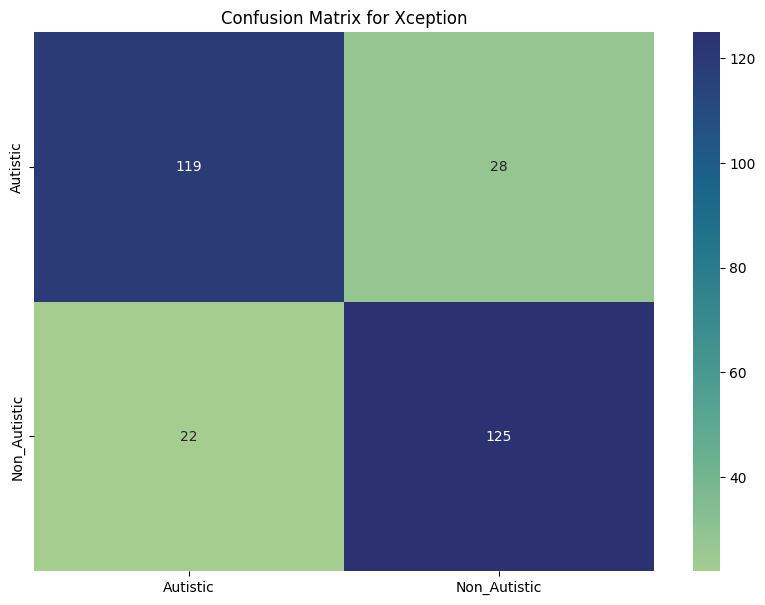

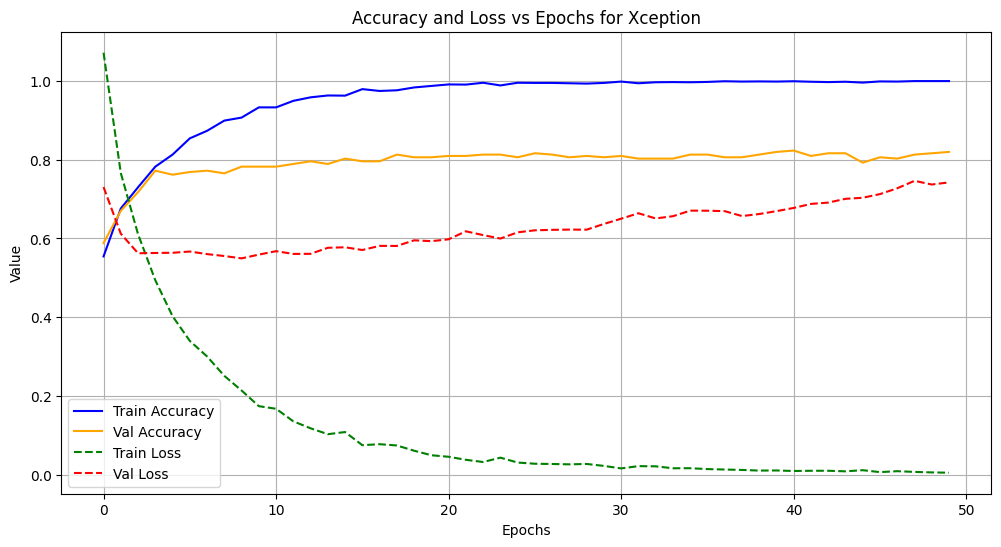

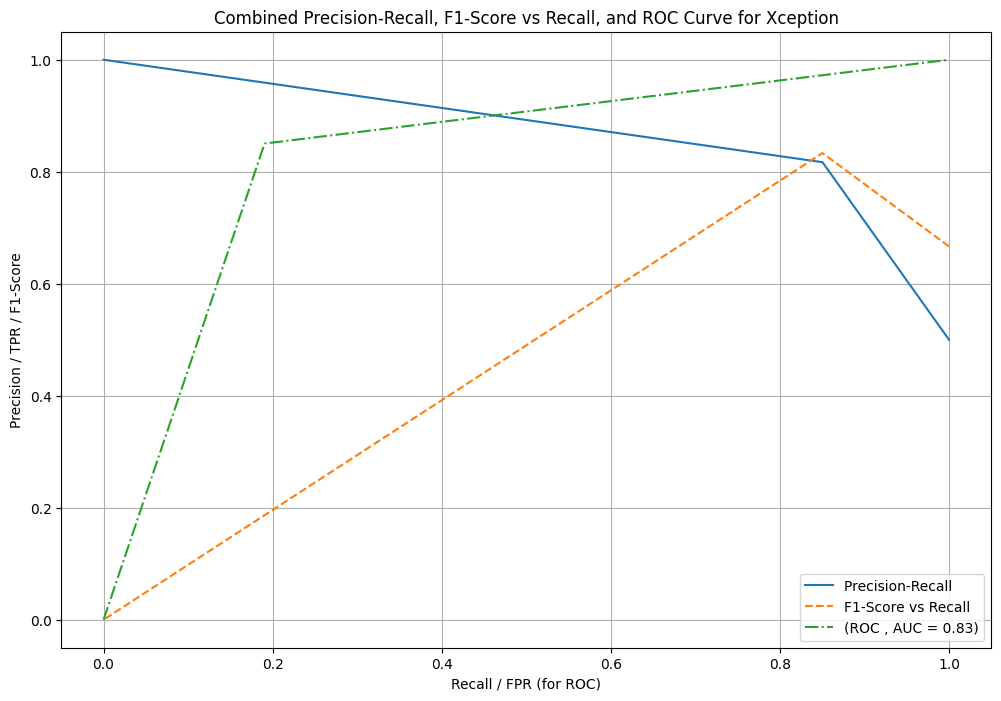

Testing random images with detection model: Xception
Creating model: MobileNetV2
Training and evaluating model: MobileNetV2
Starting epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5218 - loss: 1.2974
Epoch 1: val_accuracy improved from -inf to 0.48980, saving model to MobileNetV2_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.5218 - loss: 1.2969 - val_accuracy: 0.4898 - val_loss: 1.5712
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5766 - loss: 1.0396
Epoch 1: val_accuracy did not improve from 0.48980
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5767 - loss: 1.0392 - val_accuracy: 0.4796 - val_loss: 1.2295
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6215 - loss: 0.9009
Epoch 1: val_accuracy improved from 0.48980 to 0.51701, saving model to MobileNetV2_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6216 - loss: 0.90

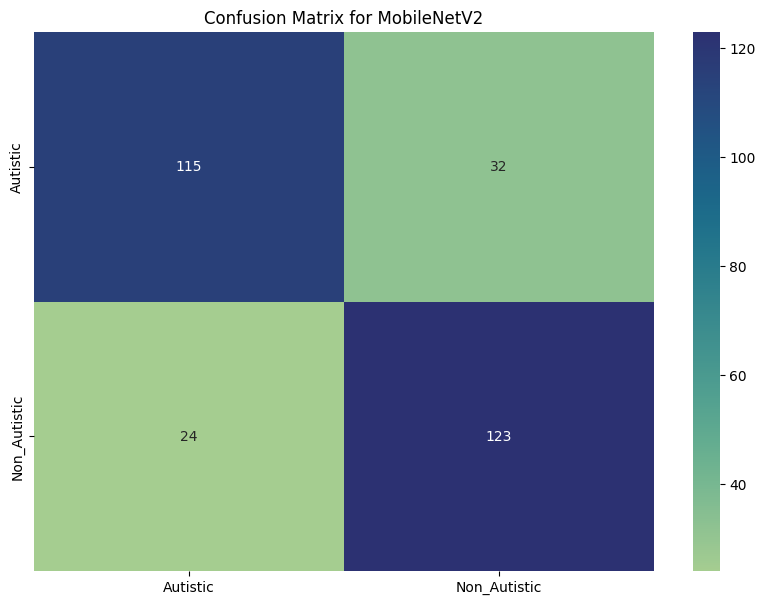

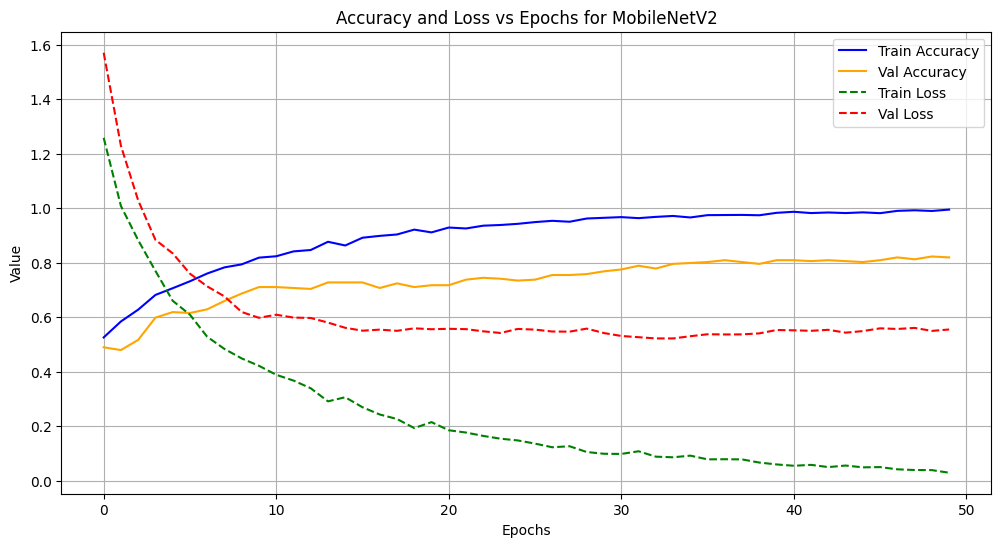

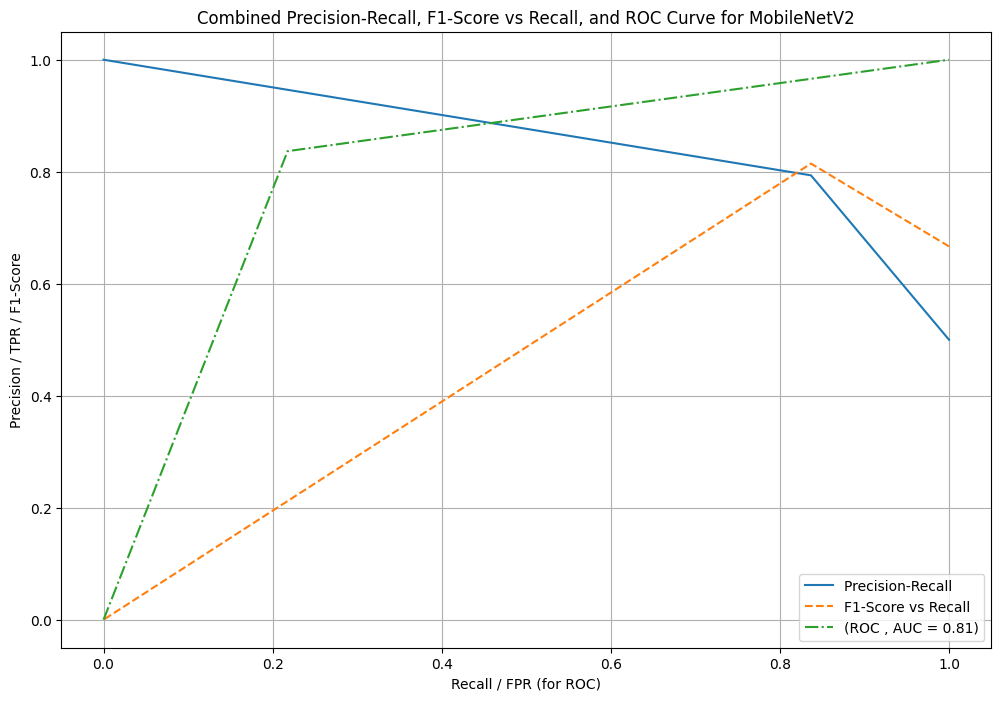

Testing random images with detection model: MobileNetV2
Creating model: InceptionV3
Training and evaluating model: InceptionV3
Starting epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.5241 - loss: 1.1804
Epoch 1: val_accuracy improved from -inf to 0.50340, saving model to InceptionV3_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 145s 905ms/step - accuracy: 0.5245 - loss: 1.1789 - val_accuracy: 0.5034 - val_loss: 1.7254
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6451 - loss: 0.8217
Epoch 1: val_accuracy improved from 0.50340 to 0.57483, saving model to InceptionV3_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.6453 - loss: 0.8213 - val_accuracy: 0.5748 - val_loss: 1.2970
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7233 - loss: 0.6246
Epoch 1: val_accuracy improved from 0.57483 to 0.63946, saving model to InceptionV3_best_model.keras
74/74 ━━━━━━━━━━━

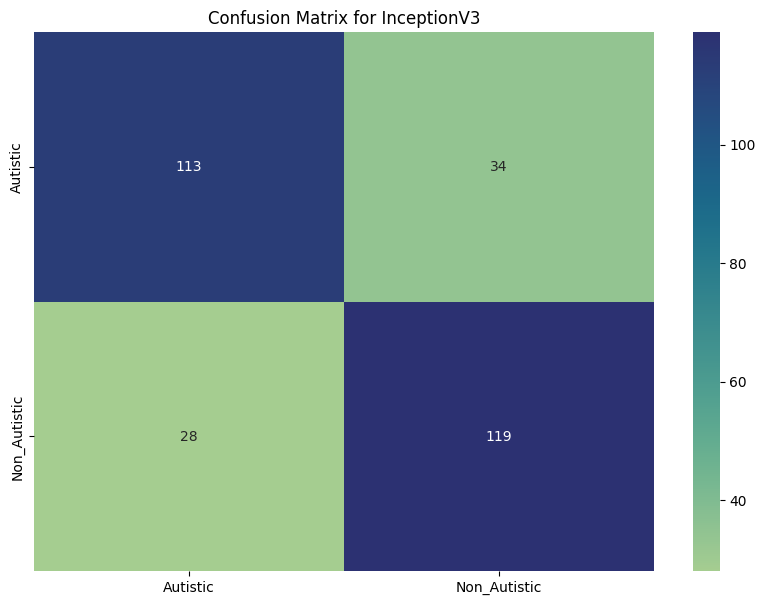

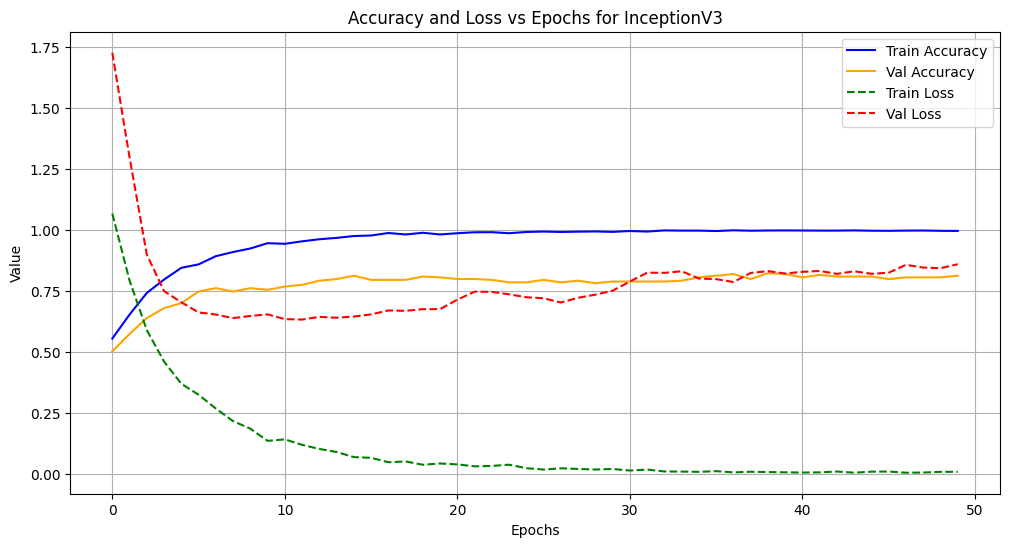

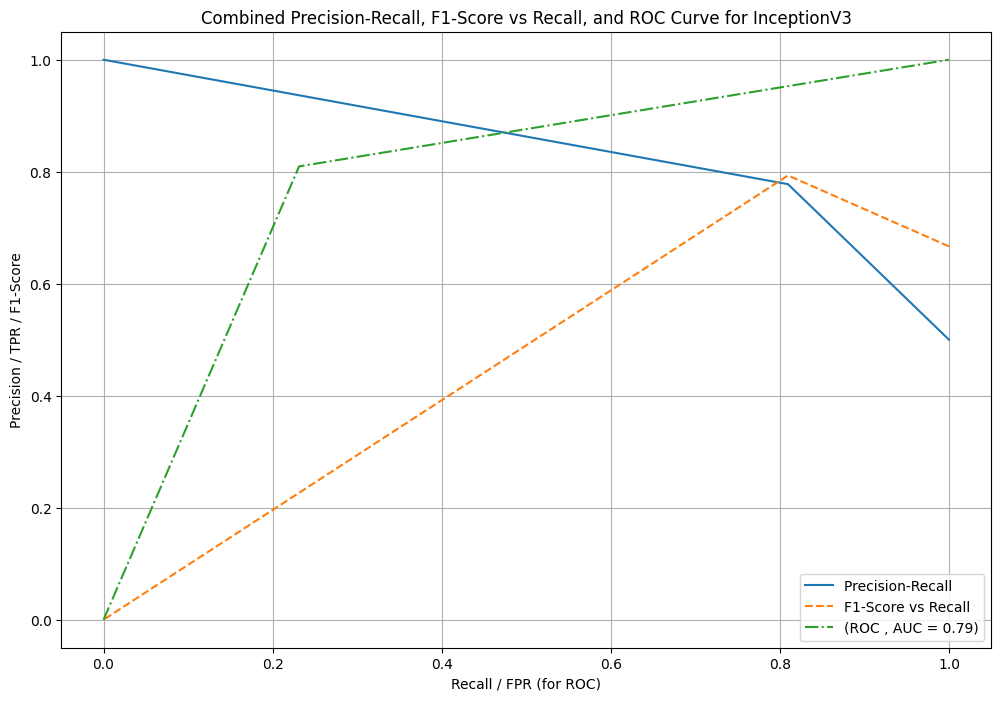

Testing random images with detection model: InceptionV3
Creating model: ResNet50
Training and evaluating model: ResNet50
Starting epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.4891 - loss: 1.4091
Epoch 1: val_accuracy improved from -inf to 0.63605, saving model to ResNet50_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 117s 760ms/step - accuracy: 0.4898 - loss: 1.4067 - val_accuracy: 0.6361 - val_loss: 0.9322
Finished epoch 1
Starting epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6898 - loss: 0.7206
Epoch 1: val_accuracy improved from 0.63605 to 0.64626, saving model to ResNet50_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.6899 - loss: 0.7202 - val_accuracy: 0.6463 - val_loss: 0.8236
Finished epoch 2
Starting epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8060 - loss: 0.4310
Epoch 1: val_accuracy improved from 0.64626 to 0.69048, saving model to ResNet50_best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 3

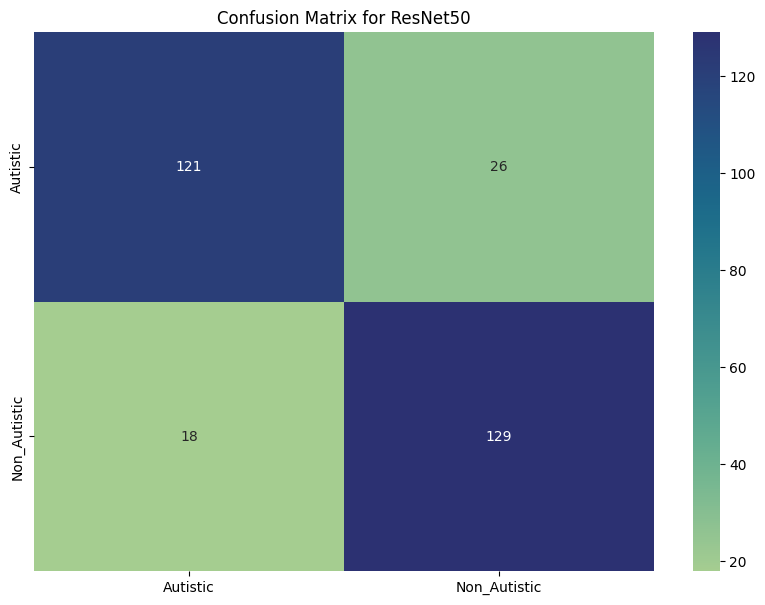

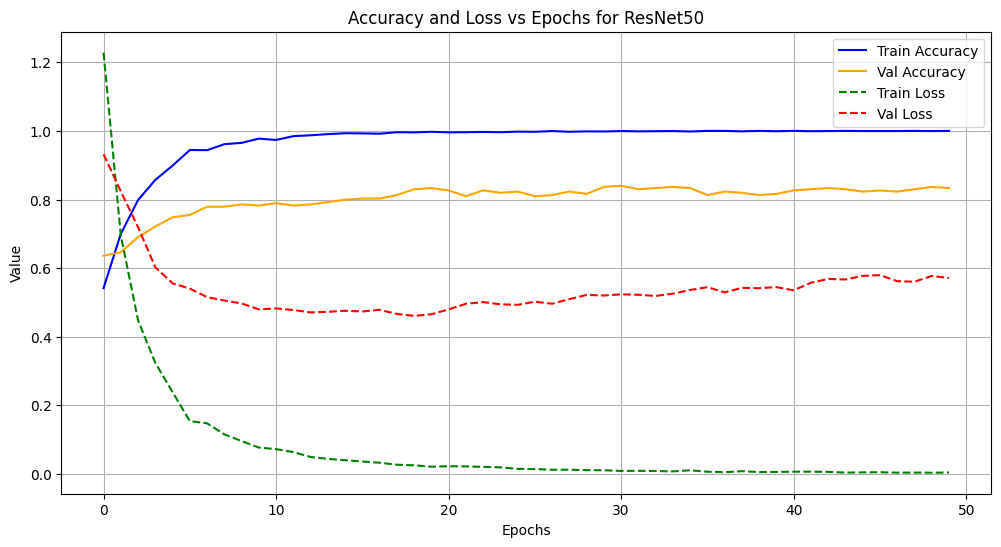

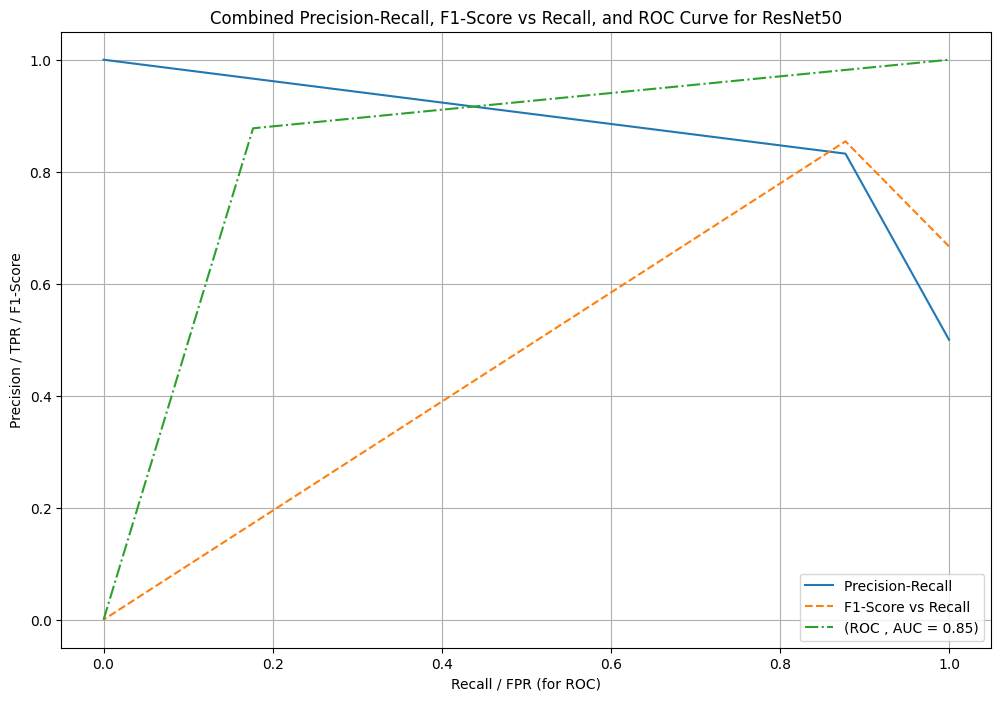

Testing random images with detection model: ResNet50


In [13]:
for model_name in model_names:
    model = create_model(model_name)
    print(f"Training and evaluating model: {model_name}")
    train_and_evaluate_model(model, train_data, val_data, test_data, model_name, class_names)

    # Test random images with detection
    print(f"Testing random images with detection model: {model_name}")
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


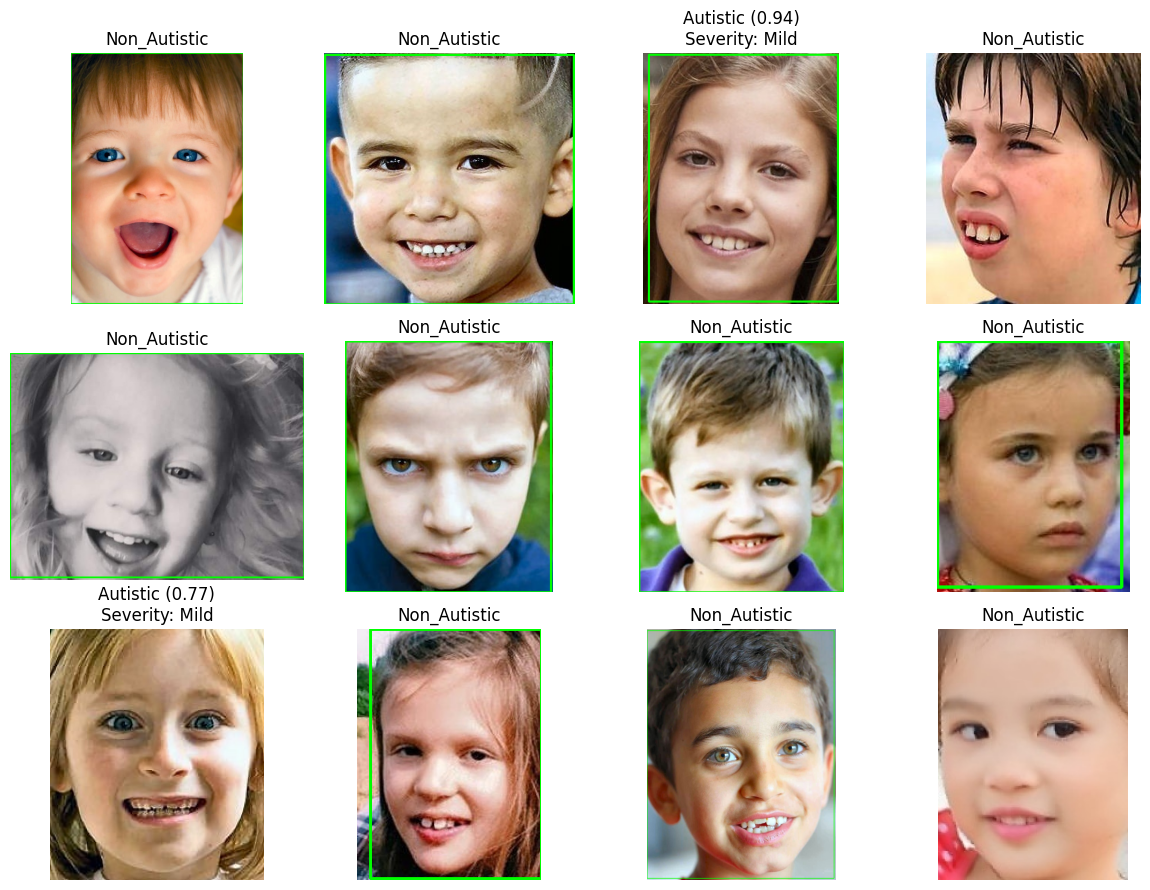

In [16]:
# Assuming you have defined class_names correctly
class_names = ["Non_Autistic", "Autistic"]  # Update with your actual class names

# Call the function with all the required arguments
test_random_images_with_detection(detection_model, test_dir, model, class_names, num_images=12)
